# Import Required Dependencies

## Tensorflow Decision Forests 

In [ ]:
from IPython import display
!pip install tensorflow_decision_forests
display.clear_output()

## Install PySpark

In [2]:
from IPython import display
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
import findspark
findspark.init()
findspark.find()

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
display.clear_output()

## Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler, Imputer, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.stat import Correlation

from pyspark.sql.types import IntegerType, DoubleType
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count, lit, udf
from pyspark.sql import SparkSession

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

#from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report

# Stage1-Preprocessing

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, isnull

spark = SparkSession.builder.getOrCreate()

# Load data into a DataFrame
df = spark.read.csv("/content/drive/MyDrive/UOW/316/316-project/data/data.csv", header=True, inferSchema=True)
df.show()  # Display the first few records

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+---------

## View General Stats

In [ ]:
# View data types and column names
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest

In [ ]:
df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+------------------+----------+------------------+------------------+------+---------+--------------------+----------+--------------+-----------------+-------------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+----------------------+----------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+--------------------+-----------------+--------------------+--------------------+------------------+--------------------+------------------+-----------------------+------------------+------------------+------------------+------------------+--------------------------+---------------------------+------------------+-----------------+-------------

In [ ]:
# Get the number of rows
num_rows = df.count()

# Get the number of columns
num_columns = len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 855969
Number of columns: 73


## Remove and check nulls before finding correlation

Remove columns with more than 50% null values.

In [ ]:
from pyspark.sql.functions import col, count, when, isnan

total_rows = df.count()

missing_data = []

for c in df.columns:
  null_count = df.select(count(when(col(c).isNull()|isnan(c), c)).alias('Count')).collect()[0]['Count']
  percent = (null_count/total_rows)*100
  missing_data.append((c, null_count, percent))

df_null = spark.createDataFrame(missing_data, ["Column Name", "Count", "Percent"])

columns_to_drop = df_null.filter(col("Percent")>50).select("Column Name").rdd.flatMap(lambda x:x).collect()

df = df.drop(*columns_to_drop)

df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 

In [ ]:
total_rows = df.count()

missing_data = []

for c in df.columns:
  null_count = df.select(count(when(col(c).isNull()|isnan(c), c)).alias('Count')).collect()[0]['Count']
  percent = (null_count/total_rows)*100
  missing_data.append((c, null_count, percent))

df_null = spark.createDataFrame(missing_data, ["Column Name", "Count", "Percent"])

df_null.show(df_null.count(), truncate=False)

+--------------------------+------+---------------------+
|Column Name               |Count |Percent              |
+--------------------------+------+---------------------+
|id                        |0     |0.0                  |
|member_id                 |0     |0.0                  |
|loan_amnt                 |0     |0.0                  |
|funded_amnt               |0     |0.0                  |
|funded_amnt_inv           |0     |0.0                  |
|term                      |0     |0.0                  |
|int_rate                  |0     |0.0                  |
|installment               |0     |0.0                  |
|grade                     |0     |0.0                  |
|sub_grade                 |0     |0.0                  |
|emp_title                 |49439 |5.7757932822333515   |
|emp_length                |0     |0.0                  |
|home_ownership            |0     |0.0                  |
|annual_inc                |0     |0.0                  |
|verification_

## Convert numerical fields to categorical

In [ ]:
from pyspark.sql.types import IntegerType, DoubleType, StringType

# Correct numerical fields that are incorrectly typed as strings
numerical_fields = ['annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
                      'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
                      'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
                      'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                      'last_pymnt_amnt', 'collections_12_mths_ex_med', 'tot_coll_amt', 'tot_cur_bal',
                      'total_rev_hi_lim']
for field in numerical_fields:
    df = df.withColumn(field, col(field).cast(DoubleType()))

In [ ]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 

In [ ]:
df.show(5)

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------+--------------------+--------+----------+-----+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|home_ownership|annual_inc|verification_status|   issue_d|pymnt_plan|       purpose|               title|zip_code|addr_state|  dti|delinq_2yrs|earliest_cr_line|in

## Apply Imputation

Apply median imputation to the columns which seem necessary for the prediction analysis.

In [ ]:
imputer = Imputer(
    inputCols=["tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim"],
    outputCols=["tot_coll_amt", "tot_cur_bal", "total_rev_hi_lim"],
    strategy="median"
)

# Apply the imputer
df = imputer.fit(df).transform(df)

In [ ]:
total_rows = df.count()

missing_data = []

for c in df.columns:
  null_count = df.select(count(when(col(c).isNull()|isnan(c), c)).alias('Count')).collect()[0]['Count']
  percent = (null_count/total_rows)*100
  missing_data.append((c, null_count, percent))

df_null = spark.createDataFrame(missing_data, ["Column Name", "Count", "Percent"])

df_null.show(df_null.count(), truncate=False)

+--------------------------+------+---------------------+
|Column Name               |Count |Percent              |
+--------------------------+------+---------------------+
|id                        |0     |0.0                  |
|member_id                 |0     |0.0                  |
|loan_amnt                 |0     |0.0                  |
|funded_amnt               |0     |0.0                  |
|funded_amnt_inv           |0     |0.0                  |
|term                      |0     |0.0                  |
|int_rate                  |0     |0.0                  |
|installment               |0     |0.0                  |
|grade                     |0     |0.0                  |
|sub_grade                 |0     |0.0                  |
|emp_title                 |49439 |5.7757932822333515   |
|emp_length                |0     |0.0                  |
|home_ownership            |0     |0.0                  |
|annual_inc                |1     |1.1682666077860296E-4|
|verification_

In [ ]:
df.show(5)

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------+--------------------+--------+----------+-----+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|home_ownership|annual_inc|verification_status|   issue_d|pymnt_plan|       purpose|               title|zip_code|addr_state|  dti|delinq_2yrs|earliest_cr_line|in

## Drop rows by checking null values and threshold

In [ ]:
df = df.drop("next_pymnt_d")
df = df.filter(col('default_ind').isNotNull())
df = df.na.drop()

In [ ]:
# Define the dominance threshold
dominance_threshold = 99.0

# List to hold columns to drop
columns_to_drop = []

# Analyze each column in the DataFrame
for col_name in df.columns:
    # Get the total number of records
    total_count = df.count()

    # Find the most frequent value and its count for the current column
    top_value_data = df.groupBy(col_name).agg(count(col_name).alias('count')).orderBy('count', ascending=False).first()

    # Calculate the percentage of the most frequent value
    if top_value_data and total_count > 0:  # Ensure there is data and avoid division by zero
        top_value_percentage = (top_value_data['count'] / total_count) * 100
        print(f"{col_name} - Top value percentage: {top_value_percentage}%")

        # Check if the top value percentage exceeds the dominance threshold
        if top_value_percentage > dominance_threshold:
            columns_to_drop.append(col_name)

# Drop columns where the top value percentage exceeds the threshold
if columns_to_drop:
    df = df.drop(*columns_to_drop)
    print(f"Dropped columns: {columns_to_drop}")
else:
    print("No columns exceeded the dominance threshold; no columns dropped.")

# Optionally, print the schema of the DataFrame to confirm the drops
df.printSchema()

id - Top value percentage: 0.00012538807609551562%
member_id - Top value percentage: 0.00012538807609551562%
loan_amnt - Top value percentage: 6.969696209769236%
funded_amnt - Top value percentage: 6.9586620590728305%
funded_amnt_inv - Top value percentage: 6.333978663964972%
term - Top value percentage: 69.47414748647063%
int_rate - Top value percentage: 4.027966556492344%
installment - Top value percentage: 0.29754590457465857%
grade - Top value percentage: 28.973422743390792%
sub_grade - Top value percentage: 6.426765840275653%
emp_title - Top value percentage: 1.6052181501747909%
emp_length - Top value percentage: 34.653377202441554%
home_ownership - Top value percentage: 50.34694880655629%
annual_inc - Top value percentage: 3.8810117313083996%
verification_status - Top value percentage: 38.147190554767%
issue_d - Top value percentage: 5.6803306232790485%
pymnt_plan - Top value percentage: 99.99937305961953%
purpose - Top value percentage: 59.45877490834132%
title - Top value perce

In [ ]:
df.show(5)

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------------+------------+-----------+----------------+-----------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|           emp_title|emp_length|home_ownership|annual_inc|verification_status|   issue_d|           purpose|               title|zip_code|addr_state|  dti|delinq_2yrs|earliest_cr_line|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_li

In [ ]:
df = df.withColumn("home_ownership",
                   when(col("home_ownership") == "NONE", "OTHER")
                   .when(col("home_ownership") == "ANY", "OTHER")
                   .otherwise(col("home_ownership")))

## Build Transformation Pipeline

In [ ]:
categorical_columns = ['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'sub_grade', 'addr_state']

# Define a UDF to extract a specific index from a SparseVector
def extract_from_vector(vec, i):
    try:
        return int(vec.toArray()[i])
    except IndexError:
        return 0

# Register the UDF
extract_from_vector_udf = udf(extract_from_vector, IntegerType())

# Filter categorical columns with fewer than 7 distinct categories
filtered_columns = [c for c in categorical_columns if df.select(c).distinct().count() < 7]

# Prepare stages for pipeline
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_Index", handleInvalid="keep") for c in filtered_columns]
encoders = [OneHotEncoder(inputCols=[f"{c}_Index"], outputCols=[f"{c}_OHE"], dropLast=False) for c in filtered_columns]

# Build the pipeline
pipeline = Pipeline(stages=indexers + encoders)
model = pipeline.fit(df)
transformed_df = model.transform(df)

# Convert one-hot encoded vectors to boolean columns for each category
for i, indexer in enumerate(indexers):
    column = indexer.getInputCol().replace('_Index', '')
    categories = model.stages[i].labels  # Fetch category labels from the indexer
    for j, category in enumerate(categories):
        # Create a new column for each category, using the UDF to extract the value from the vector
        transformed_df = transformed_df.withColumn(f"{column}_{category.replace(' ', '_')}", extract_from_vector_udf(col(f"{column}_OHE"), F.lit(j)))
    transformed_df = transformed_df.drop(f"{column}_OHE", f"{column}_Index")  # Clean up the DataFrame

# Show the transformed DataFrame structure
transformed_df.show(5, truncate=False)

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+-------------------------+----------+--------------+----------+-------------------+----------+------------------+-------------------------------------+--------+----------+-----+-----------+----------------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+--------------------------+------------+-----------+----------------+-----------+---------------+---------------+-----------------------+-------------------+------------------+--------------------+-----------------------------------+--------------------------------+----------------------------+
|id     |member_id|loan_amnt|funded_amnt|funded_amnt_inv|term      |int_rate|installment|grade|sub_grade|emp_title            

In [ ]:
# Drop the specified columns
transformed_df = transformed_df.drop("home_ownership", "verification_status", "term")

# Show the structure of the modified DataFrame
transformed_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- inq_last_6mths: double (nullable = true)
 |-- open_acc: double (nullable = true)
 |-- pub_rec: double (nullable = true)
 |-- revol_bal: double (nullable = true)
 |-- revol

In [ ]:
# List of all columns except 'default_ind'
columns = [col for col in df.columns if col != 'default_ind']

# Append 'default_ind' to the end of the list
columns.append('default_ind')

# Rearrange the DataFrame
df = df.select(*columns)

## Feature Selection by calculating Correlation Matrix for target variable

In [ ]:
# Identify numeric columns only
numeric_cols = [col for col in transformed_df.columns if isinstance(transformed_df.schema[col].dataType, (IntegerType, DoubleType))]

# Assemble the numeric features into a single vector column
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
transformed_vector = assembler.transform(transformed_df)

# Get correlation matrix
correlation_matrix = Correlation.corr(transformed_vector, "features", "pearson").head()

# Extract the correlation values
correlation_values = correlation_matrix[0].toArray()

# Find indices of the target feature for correlation, assuming target feature is in the numeric_cols
target_index = numeric_cols.index('default_ind')

# Get correlations with the target
target_correlations = correlation_values[target_index]

# Create list of (feature, correlation) tuples
feature_correlations = list(zip(numeric_cols, target_correlations))

# Sort features by absolute correlation with the target
sorted_features = sorted(feature_correlations, key=lambda x: abs(x[1]), reverse=True)

# Most and Least relevant features
most_relevant_features = sorted_features[:15]
least_relevant_features = sorted_features[-15:]

print("Most Relevant Features:")
for feature, corr in most_relevant_features:
    print(f"{feature}: {corr}")

print("\nLeast Relevant Features:")
for feature, corr in least_relevant_features:
    print(f"{feature}: {corr}")

Most Relevant Features:
default_ind: 1.0
recoveries: 0.48080265355718005
collection_recovery_fee: 0.33699004310396785
out_prncp: -0.22347217766058045
out_prncp_inv: -0.223471081994506
member_id: -0.21741507367504356
id: -0.2170605894354415
int_rate: 0.15563491442792285
total_rec_late_fee: 0.14231926960158683
total_rec_prncp: -0.09055219851601892
last_pymnt_amnt: -0.08754057732481188
inq_last_6mths: 0.0733862377428352
verification_status_Verified: 0.05158720369869314
total_rec_int: 0.048793434525129964
tot_cur_bal: -0.04545843510264604

Least Relevant Features:
revol_bal: -0.020900747805252386
pub_rec: -0.019739708239587248
total_acc: -0.01905579368206222
open_acc: -0.019024766274326487
verification_status_Not_Verified: -0.015765583916530462
dti: 0.012953023277306042
collections_12_mths_ex_med: -0.010779294773893965
delinq_2yrs: -0.00954584944071254
home_ownership_OTHER: 0.008721262667963138
home_ownership_OWN: -0.008067799392603233
installment: 0.006462360344170498
funded_amnt_inv: -0.

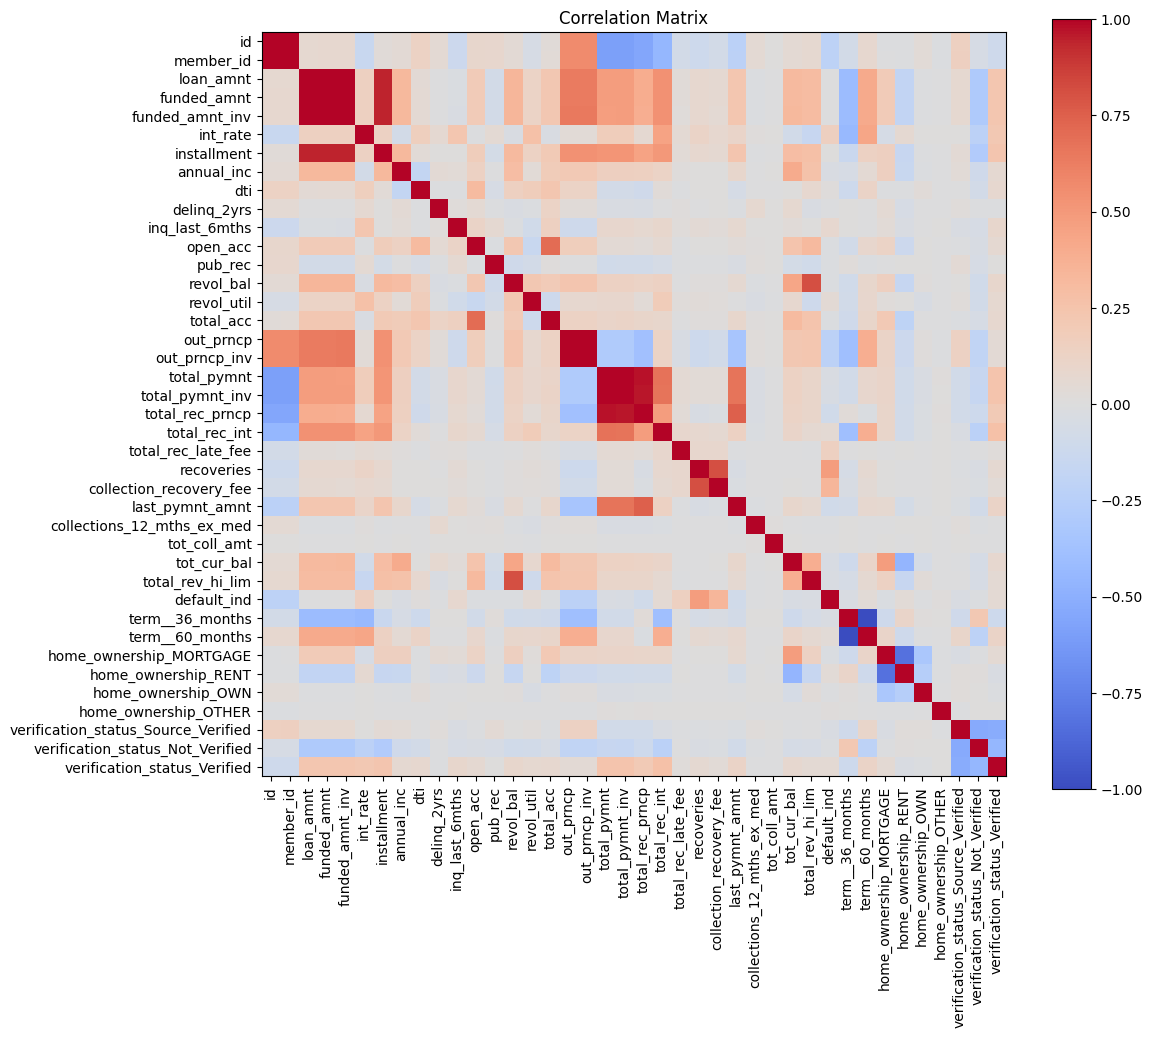

In [ ]:
# Plotting the correlation matrix with labels
plt.figure(figsize=(12, 10))
plt.imshow(correlation_values, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=90)
plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)
plt.show()

## Feature Selection using RandomForestClassifier

In [ ]:
# Identify numeric columns only
numeric_cols = [col for col in transformed_df.columns if isinstance(transformed_df.schema[col].dataType, (IntegerType, DoubleType)) and col != 'default_ind']

# Assemble features into a feature vector
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features"
)

# Initialize the Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="default_ind")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit the model
model = pipeline.fit(transformed_df)

# Get feature importances
importances = model.stages[-1].featureImportances

# Zip feature names with their importances
feature_importance_list = list(zip(numeric_cols, importances))

# Sort features by importance
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# Output the sorted feature list
print("Features sorted by importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Features sorted by importance:
recoveries: 0.3130381301614628
collection_recovery_fee: 0.2229735510786283
total_rec_prncp: 0.09842829371395921
last_pymnt_amnt: 0.05844796642477594
out_prncp_inv: 0.05782354719054393
total_pymnt: 0.044765418680427604
funded_amnt: 0.037351985289899574
out_prncp: 0.03616609589688329
installment: 0.025545307363609642
id: 0.02410369508094905
funded_amnt_inv: 0.022502505087929447
total_pymnt_inv: 0.015591436214003735
member_id: 0.01464344945621285
total_rec_late_fee: 0.007871073200638052
loan_amnt: 0.007391355774744599
int_rate: 0.005762514293555615
term__36_months: 0.0037169340978588303
term__60_months: 0.002066830134391874
total_rec_int: 0.0006789094635909348
annual_inc: 0.00046819179465948726
verification_status_Verified: 0.0002850336982954546
tot_cur_bal: 0.0002393741238996366
revol_bal: 4.852103823731774e-05
revol_util: 4.560227602573505e-05
dti: 3.2508545213591906e-05
total_rev_hi_lim: 9.902181436132885e-06
total_acc: 1.6588582229453605e-06
inq_last_6mt

In [ ]:
transformed_df = transformed_df.drop("id", "total_acc", "collections_12_mths_ex_med", "title", "open_acc", "pub_rec", "tot_coll_amt", "emp_title", "member_id")

In [ ]:
transformed_df.show(5)

+---------+-----------+---------------+--------+-----------+-----+---------+----------+----------+----------+--------------+--------+----------+-----+-----------+----------------+--------------+---------+----------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------------+-----------+----------------+---------------+---------------+-----------------------+-------------------+------------------+--------------------+-----------------------------------+----------------------------+--------------------------------+-----------+
|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|grade|sub_grade|emp_length|annual_inc|   issue_d|       purpose|zip_code|addr_state|  dti|delinq_2yrs|earliest_cr_line|inq_last_6mths|revol_bal|revol_util|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_re

## Feature Scaling

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import udf, col
from pyspark.ml.linalg import DenseVector
from pyspark.sql.types import ArrayType, DoubleType

# List of numerical columns for scaling, adjusted based on the existing columns
numerical_columns = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc',
                     'dti', 'delinq_2yrs', 'inq_last_6mths', 'revol_bal', 'revol_util', 'out_prncp',
                     'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                     'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
                     'tot_cur_bal', 'total_rev_hi_lim']

# Assemble numerical features into a single vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="unscaled_features")
transformed_df = assembler.transform(df)

# Apply StandardScaler to the assembled features
scaler = StandardScaler(inputCol="unscaled_features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(transformed_df)
transformed_df = scaler_model.transform(transformed_df)

# Define a UDF to convert Vector to array of doubles
def vector_to_array(v):
    return v.toArray().tolist()

vector_to_array_udf = udf(vector_to_array, ArrayType(DoubleType()))

# Convert the scaled_features column from vector to array
transformed_df = transformed_df.withColumn("scaled_features_array", vector_to_array_udf(col("scaled_features")))

# Overwrite the original columns with the scaled values
for i, col_name in enumerate(numerical_columns):
    transformed_df = transformed_df.withColumn(col_name, col("scaled_features_array")[i])

# Drop the intermediate columns
transformed_df = transformed_df.drop("unscaled_features", "scaled_features", "scaled_features_array")

In [ ]:
transformed_df.show(5)

+-------------------+-------------------+-------------------+--------------------+--------------------+-----+---------+----------+-------------------+----------+--------------+--------+----------+--------------------+-------------------+----------------+------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+------------+--------------------+------------------+-------------------+-------------------+---------------+---------------+-----------------------+-------------------+------------------+--------------------+-----------------------------------+----------------------------+--------------------------------+-----------+
|          loan_amnt|        funded_amnt|    funded_amnt_inv|            int_rate|         installment|grade|sub_grade|emp_length|         annual_inc|   is

## Split dataset into 80% train, 10% val, 10% test

In [ ]:
# Randomly split the DataFrame into training, validation, and testing sets
train_df, val_df, test_df = transformed_df.randomSplit([0.8, 0.1, 0.1], seed=42)

# Show the row count for each DataFrame to verify the split
print("Training Set Row Count:", train_df.count())
print("Validation Set Row Count:", val_df.count())
print("Testing Set Row Count:", test_df.count())

Training Set Row Count: 676909
Validation Set Row Count: 84420
Testing Set Row Count: 84988


In [ ]:
# Save the training set
train_df.coalesce(1).write.csv(path="/content/drive/MyDrive/train_data", mode='overwrite', header=True)

# Save the validation set
val_df.coalesce(1).write.csv(path="/content/drive/MyDrive/validation_data", mode='overwrite', header=True)

# Save the testing set
test_df.coalesce(1).write.csv(path="/content/drive/MyDrive/test_data", mode='overwrite', header=True)

In [ ]:
transformed_df.coalesce(1).write.csv(path="/content/drive/MyDrive/dataV2.csv", mode='overwrite', header=True)

# Stage2-Modelling

In [4]:
#Create Spark session
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("Error")

### Data Loading

In [7]:
# Read Spark dataframe
train_data = spark.read.csv("/content/drive/MyDrive/UOW/316/316-project/data/train_data.csv", inferSchema=True, header=True)
test_data = spark.read.csv("/content/drive/MyDrive/UOW/316/316-project/data/validation_data.csv", inferSchema=True, header=True)
val_data = spark.read.csv("/content/drive/MyDrive/UOW/316/316-project/data/test_data.csv", inferSchema=True, header=True)

# Convert Spark DataFrames to Pandas DataFrames
train_data_pd = train_data.toPandas()
val_data_pd = val_data.toPandas()
test_data_pd = test_data.toPandas()

#### Dataset format for Neural Network

In [ ]:
def encode_columns(df):
    for col_info in df.dtypes:
        if col_info[1] == 'string':
            indexer = StringIndexer(inputCol=col_info[0], outputCol=f"{col_info[0]}_encoded")
            df = indexer.fit(df).transform(df)
            df = df.drop(col_info[0])
    return df

In [ ]:
# Splitting each DataFrame into features and labels
# For training data
X_train = encode_columns(train_data).drop("member_id").toPandas()
y_train = train_data_pd[['default_ind']] # Select only the target column for labels

# For validation data
X_val = encode_columns(val_data).drop("member_id").toPandas()
y_val = val_data_pd[['default_ind']]

# For testing data
X_test = encode_columns(test_data).drop("member_id").toPandas()
y_test = test_data_pd[['default_ind']]

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

#### Dataset format for GB and RF

In [ ]:
# Convert pandas dataframe to TensorFlow dataframe (For GB and RF)
tfdf_train = tfdf.keras.pd_dataframe_to_tf_dataset(train_data_pd, label="default_ind")
tfdf_val= tfdf.keras.pd_dataframe_to_tf_dataset(val_data_pd, label="default_ind")
tfdf_test = tfdf.keras.pd_dataframe_to_tf_dataset(test_data_pd, label="default_ind")

### Tensorflow

#### Training

##### Gradient Boosted Tree

In [ ]:
## Gradient Boosted Tree
gbt = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    num_trees=5,
    max_depth=10
)
gbt.compile(metrics=["accuracy"])

# Train the model
history=gbt.fit(tfdf_train, validation_data=tfdf_val)

# Evaluate the model on the val set
val_results = gbt.evaluate(tfdf_val)

# Print the accuracy
accuracy = val_results[1]
print("Accuracy:", accuracy)

Use /tmp/tmpuvjsvtbj as temporary training directory
Reading training dataset...


Training dataset read in 0:00:18.906212. Found 676909 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(84988, shape=(), dtype=int32)
Validation dataset read in 0:00:02.413227. Found 84988 examples.
Training model...
Model trained in 0:01:29.210878
Compiling model...


Model compiled.
85/85 [==============================] - 2s 24ms/step - loss: 0.0000e+00 - accuracy: 0.9962
Accuracy: 0.9961641430854797


##### Random Forest Tree

In [ ]:
####################### Random Forest Tree #######################
rft_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    num_trees=5,
    max_depth=10)

rft_model.compile(metrics=["accuracy"])

# Train the model
rft_model.fit(tfdf_train)

Use /tmp/tmpp87gm2pb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:17.914852. Found 676909 examples.
Training model...
Model trained in 0:19:27.641824
Compiling model...
Model compiled.


##### Neural Network

In [ ]:
##################### Neural Network #####################

# define the keras model
def build_model(n_hidden=1, n_neurons=30, input_shape=(X_train.shape[1],)):

    model = Sequential()
    model.add(Dense(n_neurons,activation='relu', input_shape=input_shape))

    # Vary the number of hidden layers and number of neurons in each layer
    for _ in range(n_hidden-1):
        model.add(Dense(n_neurons, activation="relu"))

    # Fix the output layer
    model.add(Dense(1, activation="sigmoid"))

    # Fix the loss function and metrics
    model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

# build the keras model
nn_model = build_model(n_hidden=4, n_neurons=64, input_shape=(X_train.shape[1],))
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Fit the Keras model
nn_model.fit(x=X_train,
          y=y_train,
          epochs=40,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[early_stop])

Epoch 1/40
21154/21154 [==============================] - 47s 2ms/step - loss: 2.3149 - accuracy: 0.9718 - val_loss: 0.1971 - val_accuracy: 0.9508
Epoch 2/40
21154/21154 [==============================] - 46s 2ms/step - loss: 0.1604 - accuracy: 0.9664 - val_loss: 0.0645 - val_accuracy: 0.9895
Epoch 3/40
21154/21154 [==============================] - 45s 2ms/step - loss: 0.1198 - accuracy: 0.9774 - val_loss: 0.1471 - val_accuracy: 0.9662
Epoch 4/40
21154/21154 [==============================] - 45s 2ms/step - loss: 0.1280 - accuracy: 0.9776 - val_loss: 0.1124 - val_accuracy: 0.9760
Epoch 5/40
21154/21154 [==============================] - 43s 2ms/step - loss: 0.0900 - accuracy: 0.9844 - val_loss: 0.0944 - val_accuracy: 0.9808
Epoch 6/40
21154/21154 [==============================] - 45s 2ms/step - loss: 0.1018 - accuracy: 0.9791 - val_loss: 0.0488 - val_accuracy: 0.9918
Epoch 7/40
21154/21154 [==============================] - 44s 2ms/step - loss: 0.0752 - accuracy: 0.9900 - val_loss: 0

#### Evaluation

##### Gradient Boosted Tree

In [ ]:
################# Gradient Boosted Tree ##################
gbt.make_inspector().evaluation()

############### Evaluate on Validation Data ###############
probs = (gbt.predict(tfdf_val))
y_pred = probs.round(0)

# Extract the true labels from the validation dataset
y_true = np.concatenate([y for _, y in tfdf_val.as_numpy_iterator()])

# Calculate precision, recall, and ROC
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, probs)

# Print precision, recall, and ROC
print("Precision:", precision)
print("Recall:", recall)
print("ROC AUC:", roc_auc)
print()


############### Evaluate on Test Data ###############
# Make predictions on the test set
predictions = gbt.predict(tfdf_test)

# Print out the first few predictions to understand the structure
print(predictions[:5])

#Convert probabilities to class labels (using 0.5 as threshold)
y_pred = (predictions > 0.5).astype(int).flatten()

# Convert true labels to numpy array
y_true = test_data_pd["default_ind"].values

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print()

# Classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)
print()

85/85 [==============================] - 2s 26ms/step
Precision: 0.9991256830601093
Recall: 0.988538062283737
ROC AUC: 0.9996580855011945

85/85 [==============================] - 4s 47ms/step
[[2.5153703e-03]
 [6.1177392e-04]
 [2.1951289e-01]
 [9.0897046e-03]
 [9.9490535e-01]]
Confusion Matrix:
[[79842     1]
 [   69  4508]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79843
           1       1.00      0.98      0.99      4577

    accuracy                           1.00     84420
   macro avg       1.00      0.99      1.00     84420
weighted avg       1.00      1.00      1.00     84420




##### Random Forest Tree

In [ ]:
################# Random Forest Tree ##################

############### Evaluate on Validation Data ###############
# Evaluate the model on validation data
val_predictions = rft_model.predict(tfdf_val)

# Extract the true labels and predicted probabilities
true_labels_val = val_data_pd["default_ind"]
predicted_probabilities_val = val_predictions[:, 0]  # Assuming the model returns probabilities for the positive class

# Convert probabilities to binary predictions with a threshold of 0.5
predicted_labels_val = (predicted_probabilities_val >= 0.5).astype(int)

# Calculate evaluation metrics for validation data
val_accuracy = accuracy_score(true_labels_val, predicted_labels_val)
val_precision = precision_score(true_labels_val, predicted_labels_val, zero_division=0)
val_recall = recall_score(true_labels_val, predicted_labels_val, zero_division=0)
val_roc_auc = roc_auc_score(true_labels_val, predicted_probabilities_val)

# Print evaluation metrics for validation data
print(f"Validation Data Accuracy: {val_accuracy}")
print(f"Validation Data Precision: {val_precision}")
print(f"Validation Data Recall: {val_recall}")
print(f"Validation Data ROC AUC: {val_roc_auc}")

# Print the confusion matrix for validation data
val_conf_matrix = confusion_matrix(true_labels_val, predicted_labels_val)
print(f"Validation Data Confusion Matrix:\n{val_conf_matrix}")



############### Evaluate on Test Data ###############
# Evaluate the model on test data
evaluation = rft_model.evaluate(tfdf_test)
print(f"Test Data Evaluation: {evaluation}")

# Make predictions on test data
test_predictions = rft_model.predict(tfdf_test)

# Extract the true labels and predicted probabilities
true_labels_test = test_data_pd["default_ind"]
predicted_probabilities_test = test_predictions[:, 0]  # Assuming the model returns probabilities for the positive class

# Convert probabilities to binary predictions with a threshold of 0.5
predicted_labels_test = (predicted_probabilities_test >= 0.5).astype(int)

# Calculate evaluation metrics for test data
test_accuracy = accuracy_score(true_labels_test, predicted_labels_test)
test_precision = precision_score(true_labels_test, predicted_labels_test, zero_division=0)
test_recall = recall_score(true_labels_test, predicted_labels_test, zero_division=0)
test_roc_auc = roc_auc_score(true_labels_test, predicted_probabilities_test)

# Print evaluation metrics for test data
print(f"Test Data Accuracy: {test_accuracy}")
print(f"Test Data Precision: {test_precision}")
print(f"Test Data Recall: {test_recall}")
print(f"Test Data ROC AUC: {test_roc_auc}")

# Print the confusion matrix for test data
test_conf_matrix = confusion_matrix(true_labels_test, predicted_labels_test)
print(f"Test Data Confusion Matrix:\n{test_conf_matrix}")


85/85 [==============================] - 5s 57ms/step
Validation Data Accuracy: 0.9992822516119922
Validation Data Precision: 1.0
Validation Data Recall: 0.9868079584775087
Validation Data ROC AUC: 0.9998784630816463
Validation Data Confusion Matrix:
[[80364     0]
 [   61  4563]]
85/85 [==============================] - 6s 67ms/step - loss: 0.0000e+00
Test Data Evaluation: 0.0
85/85 [==============================] - 5s 56ms/step
Test Data Accuracy: 0.9989931295901445
Test Data Precision: 1.0
Test Data Recall: 0.9814288835481757
Test Data ROC AUC: 0.9999876710743107
Test Data Confusion Matrix:
[[79843     0]
 [   85  4492]]


##### Neural Network

In [ ]:
test_results = nn_model.evaluate(X_test, y_test, verbose=0)

print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Test Loss: 0.028894230723381042
Test Accuracy: 0.9934493899345398


#### Tuning

In [ ]:
!pip install tensorflow==2.12.0
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
import tensorflow_decision_forests as tfdf

class ModelTuner:
    def __init__(self, model_type):
        self.model_type = model_type
        self.model = None
        self.grid_search = None

    def tune_parameters(self, X_train, y_train, param_grid):
        if self.model_type == 'GBT':

            # Add discretized hyperparameters for the tuner
            tuner = tfdf.tuner.RandomSearch(num_trials=3)
            tuner.choice("max_depth", param_grid.get("max_depth", []))
            tuner.choice("num_trees", param_grid.get("num_trees", []))

            # Create GBT model with a random search tuner
            self.model = tfdf.keras.GradientBoostedTreesModel(
                task=tfdf.keras.Task.CLASSIFICATION,
                tuner=tuner
            )
            self.model.compile(metrics=["accuracy"])

            # Cannot use val when tuning according to documentation
            self.model.fit(X_train)

            # Display the tuning logs.
            tuning_logs = self.model.make_inspector().tuning_logs()

            print()
            print("Best Hyperparameters")
            print(tuning_logs[tuning_logs.best].iloc[0])

            # Evaluate the model on the val set
            val_results = self.model.evaluate(y_train)

            # Print the accuracy
            accuracy = val_results[1]
            print("Accuracy:", accuracy)

            return tuning_logs

        elif self.model_type == 'NN':
            # Create and tune a Neural Network model using KerasClassifier wrapped with GridSearchCV
            self.model = KerasClassifier(build_fn=build_model, verbose=0)
            self.grid_search = GridSearchCV(self.model, param_grid, cv=3, scoring='accuracy')
            self.grid_search.fit(X_train, y_train, batch_size=32, validation_data=(X_val, y_val))
            print("Best Parameters:", self.grid_search.best_params_)
            return self.grid_search.best_params_

        elif self.model_type == 'RF':
            # Add discretized hyperparameters for the tuner
            tuner = tfdf.tuner.RandomSearch(num_trials=3)
            tuner.choice("max_depth", param_grid.get("max_depth", []))
            tuner.choice("num_trees", param_grid.get("num_trees", []))

            # Create RF model with a random search tuner
            self.model = tfdf.keras.RandomForestModel(
                task=tfdf.keras.Task.CLASSIFICATION,
                tuner=tuner
            )

            self.model.compile(metrics=["accuracy"])

             # Cannot use val when tuning according to documentation
            self.model.fit(X_train)

            # Display the tuning logs.
            tuning_logs = self.model.make_inspector().tuning_logs()

            print()
            print("Best Hyperparameters")
            print(tuning_logs[tuning_logs.best].iloc[0])

            # Evaluate the model on the val set
            val_results = self.model.evaluate(y_train)

            # Print the accuracy
            accuracy = val_results[1]
            print("Accuracy:", accuracy)

            return tuning_logs

        else:
            raise ValueError("Unsupported model type")


###### Gradient Boosted Tree

In [ ]:
model_tuner = ModelTuner(model_type='GBT')
param_grid = {
    "num_trees": [10, 15],
    "max_depth": [5, 10]
}
tunning_logs = model_tuner.tune_parameters(X_train=tfdf_train, y_train=tfdf_val, param_grid=param_grid)

Use /tmp/tmpnxzfkiuu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:24.304041. Found 676909 examples.
Training model...
Model trained in 0:09:05.484934
Compiling model...
Model compiled.



Best Hyperparameters
score               -0.051649
evaluation_time    544.429521
best                     True
max_depth                  10
num_trees                  15
Name: 2, dtype: object
85/85 [==============================] - 3s 26ms/step - loss: 0.0000e+00 - accuracy: 0.9984
Accuracy: 0.9983644485473633


##### Random Forest Tree

In [ ]:
model_tuner = ModelTuner(model_type='RF')
param_grid = {
    "num_trees": [10, 15],
    "max_depth": [5, 10]
}
rf_tunning_logs = model_tuner.tune_parameters(X_train=tfdf_train, y_train=tfdf_val, param_grid=param_grid)

Use /tmp/tmpsuemwvrm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:48.127731. Found 676909 examples.
Training model...
Model trained in 0:02:59.810163
Compiling model...
Model compiled.

Best Hyperparameters
score                0.996474
evaluation_time    177.317566
best                     True
max_depth                  10
num_trees                  15
Name: 2, dtype: object
85/85 [==============================] - 11s 35ms/step - loss: 0.0000e+00 - accuracy: 0.9978
Accuracy: 0.9977761507034302


##### Neural Network

In [ ]:
model_tuner = ModelTuner(model_type='NN')
param_grid = {
    'n_hidden': [4, 8],
    'n_neurons': [64, 128]
}
best_params = model_tuner.tune_parameters(X_train, y_train, param_grid)
best_model = build_model(**best_params)
history = best_model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=0, validation_data=(X_test, y_test),
          callbacks=[early_stop])

21169/21169 [==============================] - 77s 4ms/step - loss: 18.6434 - accuracy: 0.9914 - val_loss: 3.3928 - val_accuracy: 0.9975


In [ ]:
test_results = best_model.evaluate(X_test, y_test, verbose=0)

print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Test Loss: 0.034795477986335754
Test Accuracy: 0.9978758692741394


In [ ]:
# Get the best parameter
print("Best parameters found: ", best_params)

Best parameters found:  {'n_hidden': 1, 'n_neurons': 128}

## PySpark

In [8]:
from pyspark.ml.classification import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

#### Preprocessing

In [9]:
# Select features
# Define the feature columns (excluding 'member_id' and 'default_ind')
feature_cols = [
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_length',
 'annual_inc',
 'issue_d',
 'purpose',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'revol_bal',
 'revol_util',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'term__36_months',
 'term__60_months',
 'home_ownership_MORTGAGE',
 'home_ownership_RENT',
 'home_ownership_OWN',
 'home_ownership_OTHER',
 'verification_status_Source_Verified',
 'verification_status_Verified',
 'verification_status_Not_Verified'
]

# Separate numeric and string columns
numeric_cols = [
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'revol_bal',
 'revol_util',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'term__36_months',
 'term__60_months',
 'home_ownership_MORTGAGE',
 'home_ownership_RENT',
 'home_ownership_OWN',
 'home_ownership_OTHER',
 'verification_status_Source_Verified',
 'verification_status_Verified',
 'verification_status_Not_Verified'
]

string_cols = [
 'grade',
 'sub_grade',
 'emp_length',
 'issue_d',
 'purpose',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'last_credit_pull_d'
]

# Handle numeric columns and string columns
# Index and encode string columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep") for col in string_cols]
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") for col in string_cols]

In [10]:
# Assemble all features
assembler = VectorAssembler(inputCols=numeric_cols + [col + "_encoded" for col in string_cols], outputCol="features")

# Index the target variable
indexer = StringIndexer(inputCol="default_ind", outputCol="label", handleInvalid="keep")

#### Training and Tuning

##### Neural Network

In [ ]:
# Define the layers for the MLP model
input_size = len(train_data.head().features)
layers = [input_size, 64, 32, 2]

# Instantiate the MLP model
mlp_classifier = MultilayerPerceptronClassifier(labelCol='label',
                                                featuresCol='features',
                                                maxIter=100,
                                                layers=layers,
                                                seed=1234)

In [ ]:
# Define the parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(mlp_classifier.layers, [[input_size, 64, 2], [input_size, 128, 2], [input_size, 256, 2]])
             .addGrid(mlp_classifier.solver, ['gd', 'l-bfgs'])
             .build())

# Define the CrossValidator
crossval = CrossValidator(estimator=mlp_classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)

In [ ]:
# Early stopping criteria
early_stopping_rounds = 3
best_score = 0.0
patience = 0

# Custom cross-validation loop
param_maps = crossval.getEstimatorParamMaps()
nn_spark_model = None
for i, param_map in enumerate(param_maps):
    # Set the parameters for the current iteration
    model = mlp_classifier.copy(param_map)
    # Perform cross-validation
    cv_model = model.fit(train_data)

    # Evaluate the model
    predictions = cv_model.transform(val_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                                  predictionCol="prediction",
                                                  metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    print(f'Param map: {param_maps}')
    print(f"Iteration {i+1}/{len(param_maps)}, Accuracy: {accuracy}")

    # Check for early stopping
    if accuracy > best_score:
        best_score = accuracy
        nn_spark_model = cv_model
        patience = 0
    else:
        patience += 1

    if patience >= early_stopping_rounds:
        print("Early stopping triggered")
        break

Iteration 1/9, Accuracy: 0.9907012556266288
Iteration 2/9, Accuracy: 0.9907012556266288
Iteration 3/9, Accuracy: 0.9907012556266288
Iteration 4/9, Accuracy: 0.9990168206586117
Iteration 5/9, Accuracy: 0.9990642027955461
Iteration 6/9, Accuracy: 0.9990405117270789
Iteration 7/9, Accuracy: 0.9989694385216773
Iteration 8/9, Accuracy: 0.999360341151386
Iteration 9/9, Accuracy: 0.9992892679459844


##### Decision Tree

In [11]:
# Define the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Create a pipeline to assemble the steps
pipeline = Pipeline(stages=indexers + encoders + [assembler, indexer, dt])

# Define the parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 10, 15])
             .addGrid(dt.minInstancesPerNode, [1, 5, 10])
             .build())

# Define the CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3)


In [ ]:
# Early stopping criteria
early_stopping_rounds = 3
best_score = 0.0
patience = 0

# Custom cross-validation loop
param_maps = crossval.getEstimatorParamMaps()
dt_spark_model = None

for i, param_map in enumerate(param_maps):
    # Set the parameters for the current iteration
    model = pipeline.copy(param_map)
    # Perform cross-validation
    cv_model = model.fit(train_data)

    # Evaluate the model
    predictions = cv_model.transform(val_data)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)

    print(f"Iteration {i+1}/{len(param_maps)}, Accuracy: {accuracy}")

    # Check for early stopping
    if accuracy > best_score:
        best_score = accuracy
        dt_spark_model = cv_model
        patience = 0
    else:
        patience += 1

    if patience >= early_stopping_rounds:
      print("Early stopping triggered")
      break

Iteration 1/9, Accuracy: 0.9907012556266288
Iteration 2/9, Accuracy: 0.9907012556266288
Iteration 3/9, Accuracy: 0.9907012556266288
Iteration 4/9, Accuracy: 0.9990168206586117
Iteration 5/9, Accuracy: 0.9990642027955461
Iteration 6/9, Accuracy: 0.9990405117270789
Iteration 7/9, Accuracy: 0.9989694385216773
Iteration 8/9, Accuracy: 0.999360341151386
Iteration 9/9, Accuracy: 0.9992892679459844


##### Random Forest

In [ ]:
# Import Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier

# Initialize the Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol='label')

# Define a parameter grid to search through
param_grid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [5, 10, 15])
               .addGrid(rf.numTrees, [10, 20, 30])
               .build())

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Define cross-validator
cross_val = CrossValidator(estimator=rf,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=3)

# Fit cross-validator to train data
cv_model = cross_val.fit(train_data)

# Get best model from cross-validation
best_rf_model = cv_model.bestModel

# Print model parameters
print("Model Parameters:")
for param, value in best_rf_model.extractParamMap().items():
    print(f"{param}: {value}")

Model Parameters:
RandomForestClassifier_2587b6c40a10__bootstrap: True
RandomForestClassifier_2587b6c40a10__cacheNodeIds: False
RandomForestClassifier_2587b6c40a10__checkpointInterval: 10
RandomForestClassifier_2587b6c40a10__featureSubsetStrategy: auto
RandomForestClassifier_2587b6c40a10__featuresCol: features
RandomForestClassifier_2587b6c40a10__impurity: gini
RandomForestClassifier_2587b6c40a10__labelCol: default_ind
RandomForestClassifier_2587b6c40a10__leafCol: 
RandomForestClassifier_2587b6c40a10__maxBins: 32
RandomForestClassifier_2587b6c40a10__maxDepth: 5
RandomForestClassifier_2587b6c40a10__maxMemoryInMB: 256
RandomForestClassifier_2587b6c40a10__minInfoGain: 0.0
RandomForestClassifier_2587b6c40a10__minInstancesPerNode: 1
RandomForestClassifier_2587b6c40a10__minWeightFractionPerNode: 0.0
RandomForestClassifier_2587b6c40a10__numTrees: 20
RandomForestClassifier_2587b6c40a10__predictionCol: prediction
RandomForestClassifier_2587b6c40a10__probabilityCol: probability
RandomForestClass

#### Evaluation

##### Neural Network

In [ ]:
# Predict the model on test set
predictions = nn_spark_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Overall accuracy rate:", accuracy)

Overall accuracy rate: 0.9919900320398718

##### Decision Tree

In [ ]:
# Make predictions on the validation data
predictions = dt_spark_model.transform(val_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Best model accuracy: {accuracy}")

Best model accuracy: 0.9992892679459844

##### Random Forest

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Make predictions on the test and validation data using the best model
test_predictions_tuned = best_rf_model.transform(test_data)
val_predictions_tuned = best_rf_model.transform(val_data)

# Define the threshold for binary classification
threshold = 0.5
target_column = "default_ind"

# Define evaluators
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol=target_column)

# Define a function to calculate precision and recall manually
def calculate_precision_recall(predictions, threshold):
    true_positives = predictions.filter((predictions[target_column] == 1) & (predictions["prediction"] == 1)).count()
    false_positives = predictions.filter((predictions[target_column] == 0) & (predictions["prediction"] == 1)).count()
    false_negatives = predictions.filter((predictions[target_column] == 1) & (predictions["prediction"] == 0)).count()

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall

# Evaluate the tuned model on the test set
test_auc_tuned = multiclass_evaluator.evaluate(test_predictions_tuned, {multiclass_evaluator.metricName: "areaUnderROC"})
test_accuracy_tuned = multiclass_evaluator.evaluate(test_predictions_tuned, {multiclass_evaluator.metricName: "accuracy"})
test_precision_tuned, test_recall_tuned = calculate_precision_recall(test_predictions_tuned, threshold)
test_f1_tuned = 2 * (test_precision_tuned * test_recall_tuned) / (test_precision_tuned + test_recall_tuned)

print("Tuned Model Evaluation on Test Set:")
print(f"AUC: {test_auc_tuned}")
print(f"Accuracy: {test_accuracy_tuned}")
print(f"Precision: {test_precision_tuned}")
print(f"Recall: {test_recall_tuned}")
print(f"F1 Score: {test_f1_tuned}")

Tuned Model Evaluation on Test Set:
AUC: 0.9976899804742231
Accuracy: 0.9979526521391255
Precision: 0.9995509654243376
Recall: 0.96280276816609
F1 Score: 0.9808327825512226


In [ ]:
# Stop the Spark session
spark.stop()